In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit

In [2]:
from RockPhysicsModule import Berryman
from RockPhysicsModule import Berryman_F
from RockPhysicsModule import DEM
from RockPhysicsModule import double_porosity_model_DEM
from RockPhysicsModule import crack_density

# Help and plotting functions

In [107]:
def Kp_asp_f(method_type, Kp_all, fluid_type, criterion):
    
    """"
    Help to correlate the crack charasteristics (aspect artio and volume fraction) with the f-parameter 
    via finding the closest values between the elastic properties of the models Type-1 and Type-2 
    for a chosen range of shperical porosities.
    
    The elastis properties were calculated with the chosen pair of methods: 
    (1) GSA-self consistent- GSA-f --- 'GSA'
    (2) self-consistent and modified Berryman's methods --- 'BBf'
    (3) the DEM and modified Berryman's methods --- 'DEMBf'
    
    In the case of GSA-SC and Berryman-SC, the pores, cracks, and calcite grains are embedded 
    in effective media simultaneously, while in the case of the DEM, the saturated voids are inserted
    in the calcite matrix sequentially: cracks at first and then the spherical pores.
    
    Input parameters
    -----------------
    Kp_all      list, range volume fraction of spherical porosity
    fluid type  str, 'w' - brine, 'g' - gas, 'o' - oil
    criterion   int, 1 - difference between the effective elastic moduli of models 
                         Type-1 and Type2 is less than 0.1 GPa
                     2 - difference between the effective elastic moduli of models 
                         Type-1 and Type2 is less than 1%
    Returns:
    --------
    p_all       dict, it contains the matching elastic moduli of Type-1 and Type-2 models 
                and corresponding to the moduli parameters of the models
                (crack charasteristics (aspect artio and volume fraction) and f-parameter) 
                for a given range of the fixed spherical porosity.
    """
    
    N = 1024        # number of samples
    K_m = 72.0      # calcite bulk modulus
    mu_m = 32.0     # calcite shear modulus
    mu_fluid = 0.0  # fluid bulk modulus
    asp_pore = 0.99 # shperical pore aspect ratio
    asp_m = 0.99    # calcite grain aspect ratio
    
    p_all = {'Kp':[], 'p1':[], 'p2':[]}
        
    if (method_type == 'BBf'):
        
        #os.chdir("C:...\\Data\\Berryman_DEM")
        
        if fluid_type == 'w':
            #brine
            K_fluid = 2.5
            param_d = pd.read_csv('Param_values_brine.txt', delimiter='\s+', 
                                header=None,names=['log10_phi_crack','log10_a_crack'],usecols=np.r_[:,0:2])
        elif fluid_type == 'g':
            #gas
            K_fluid = 0.006
            param_d = pd.read_csv('Param_values_gas.txt', delimiter='\s+', 
                                  header=None,names=['log10_phi_crack','log10_a_crack'],usecols=np.r_[:,0:2])
        
        for Kpi in Kp_all:
            # Berryman double porosity model 
            K = np.array([K_fluid,K_fluid, K_m])
            mu = np.array([mu_fluid,mu_fluid, mu_m])
            nparam = 3
            
            K_b = np.zeros(len(param_d))
            mu_b = np.zeros(len(param_d))
            
            for j in range(len(param_d)):
                Kp_crack = 10**param_d.iloc[j,0]
                Kp_m = 1-Kp_crack-Kpi
                Kp = np.array([Kp_crack,Kpi,Kp_m])
                asp_crack = 10**param_d.iloc[j,1]
                asp = np.array([asp_crack,asp_pore, asp_m])
                K_b[j], mu_b[j] = Berryman(nparam, Kp,asp,K,mu)
            ###    
            data_d = pd.DataFrame()
            data_d['K_d'] = K_b
            data_d['mu_d'] = mu_b
            data_d['log10_phi_crack'] = param_d.iloc[:,0]
            data_d['log10_a_crack'] = param_d.iloc[:,1]
            
            # Berryman f-model
            K = np.array([K_fluid, K_m])
            mu = np.array([mu_fluid, mu_m])
            nparam = 2
            asp = np.array([asp_pore, asp_m])
            Kp = np.array([Kpi,1-Kpi])
            
            f = np.linspace(0.0, 0.99, N)
            
            K_bf = np.zeros(len(f))
            mu_bf = np.zeros(len(f))
            
            for j in range(len(f)):
                K_bf[j], mu_bf[j] = Berryman_F(nparam,Kp,asp,K,mu,f[j])
            ###
            data_f = pd.DataFrame()
            data_f['K_f'] = K_bf
            data_f['mu_f'] = mu_bf
            data_f['f'] = f
            
            
            p1i, p2i = comparison_eff_prop(data_d, data_f, criterion)
            ####comparison
            p_all['p1'].append(p1i)
            p_all['p2'].append(p2i)
            p_all['Kp'].append(Kpi)
            
    elif (method_type == 'DEMBf'):
        #os.chdir("C:...\\Data\\Berryman_DEM")
        
        if fluid_type == 'w':
            #brine
            K_fluid = 2.5
            param_d = pd.read_csv('Param_values_brine.txt', delimiter='\s+', 
                                header=None,names=['log10_phi_crack','log10_a_crack'],usecols=np.r_[:,0:2])
        elif fluid_type == 'g':
            #gas
            K_fluid = 0.006 
            param_d = pd.read_csv('Param_values_gas.txt', delimiter='\s+', 
                                  header=None,names=['log10_phi_crack','log10_a_crack'],usecols=np.r_[:,0:2])
        
        for Kpi in Kp_all:
            #double DEM model
            
            K_dem = np.zeros(len(param_d))
            mu_dem = np.zeros(len(param_d))
            
            for j in range(len(param_d)):
                Kp_crack = 10**param_d.iloc[j,0]
                asp_crack = 10**param_d.iloc[j,1]
                K_dem[j], mu_dem[j] = double_porosity_model_DEM(K_m,mu_m,K_fluid,mu_fluid,Kpi,
                                                                Kp_crack, asp_pore, asp_crack)
            ###
            data_d = pd.DataFrame()
            data_d['K_d'] = K_dem
            data_d['mu_d'] = mu_dem
            data_d['log10_phi_crack'] = param_d.iloc[:,0]
            data_d['log10_a_crack'] = param_d.iloc[:,1]
            
            
            # Berryman_f model
            K = np.array([K_fluid, K_m])
            mu = np.array([mu_fluid, mu_m])
            nparam = 2
            asp = np.array([asp_pore, asp_m])
            Kp = np.array([Kpi,1-Kpi])
            
            f = np.linspace(0.0, 0.99, N)
            K_bf = np.zeros(N)
            mu_bf = np.zeros(N)
            
            for j in range(N):
                K_bf[j], mu_bf[j] = Berryman_F(nparam,Kp,asp,K,mu,f[j])
            ###
            data_f = pd.DataFrame()
            data_f['K_f'] = K_bf
            data_f['mu_f'] = mu_bf
            data_f['f'] = f
            
            
            p1i, p2i = comparison_eff_prop(data_d, data_f, criterion)
            ####comparison
            p_all['p1'].append(p1i)
            p_all['p2'].append(p2i)
            p_all['Kp'].append(Kpi)
                 
    elif method_type == 'GSA':
       
        #os.chdir("C:...\\Data\\GSA_methods")
        
        if fluid_type == 'w':
            K_fluid = 2.5
            #brine
            data_f = pd.read_csv('F_GSA_300_brine.txt', delimiter='\s+', skiprows=1, header=None,
                       names=['K_f', 'mu_f', 'f'], usecols=np.r_[:,0:3])
            data_d = pd.read_csv('Double_GSA_1800_brine.txt', delimiter='\s+', skiprows=1, header=None,
                     names=['K_d', 'mu_d','log10_phi_crack','log10_a_crack'],usecols=np.r_[:,0:4])
        elif fluid_type == 'g':
            K_fluid = 0.006
            #gas
            data_f = pd.read_csv('F_GSA_300_gas.txt', delimiter='\s+', skiprows=1, header=None, 
                       names=['K_f', 'mu_f', 'f'],usecols=np.r_[:,0:3])
            data_d = pd.read_csv('Double_GSA_1800_gas.txt', delimiter='\s+', skiprows=1, header=None,
                     names=['K_d', 'mu_d','log10_phi_crack','log10_a_crack'],usecols=np.r_[:,0:4])

        n1 = 300
        n2 = 1800
        for i in range(len(Kp_all)):
            p1i, p2i = comparison_eff_prop(data_d[n2*i:n2*i+n2],data_f[n1*i:n1*i+n1], criterion)
            p_all['Kp'].append(Kp_all[i])
            p_all['p1'].append(p1i)
            p_all['p2'].append(p2i)
 
    return p_all


def comparison_eff_prop(data_d, data_f, criterion):
    
    """
    Help to find the closest values between the elastic properties of the models Type-1 and Type-2 
    for a given spherical porosity.
    
    Input parameters:
    -----------------
    data_d       pd.DataFrame, it contains the effective elastic moduli 
                               and parameters of the double porosity model(Type-1)
    data_f       pd.DataFrame, it contains the effective elastic moduli 
                               and parameters of f-model(Type-2)
    criterion    int, 1 - difference between the effective elastic moduli of models 
                         Type-1 and Type2 is less than 0.1 GPa
                     2 - difference between the effective elastic moduli of models 
                         Type-1 and Type2 is less than 1%
    Returns:
    ---------
    p1           pd.DataFrame, it contains the chosen elastic moduli of the Type-1 model
                               and corresponding parameters of this model (crack aspect artio and volume fraction) 
    
    p2           pd.DataFrame, it contains the chosen elastic moduli of the Type-2 model and
                               and the corresponding f-parameter)
    """

    data_dL = data_d.values.tolist()
    data_fL = data_f.values.tolist()
     
    p_1 = []
    p_2 = []
     
    for row_1 in data_dL:
        for row_2 in data_fL:
             # choose criterion
                if criterion==1:
                    k = abs(row_2[0] - row_1[0])
                    m = abs(row_2[1] - row_1[1])
                    if  (k<= 0.1) & (m <= 0.1):
                        p_1.append(row_1)
                        p_2.append(row_2)
                    else:
                        continue
                elif criterion==2:
                    k = abs(row_2[0] - row_1[0])/row_2[0]
                    m = abs(row_2[1] - row_1[1])/row_2[1]
                    if  (k<= 0.01) & (m <= 0.01):
                        p_1.append(row_1)
                        p_2.append(row_2)
                    else:
                         continue
                            
    p1 = pd.DataFrame (p_1, columns = ['K_d', 'mu_d','log10_phi_crack', 'log10_a_crack'])   
    p2 = pd.DataFrame (p_2, columns = ['K_f', 'mu_f','f'])
    
    return p1, p2

In [101]:
def plot_scatter(p_all, Kp):
    """
    Scatter plots of crack aspect ratio vs volume fraction (porosity) and f-parameter 
    as a color for a fixed range of spherical porosities.
    
    Input parameters:
    -----------------
    p_all      dict, contains the matching elastic moduli of Type-1 and Type-2 models 
                     and corresponding to the moduli parameters of the models:
                     crack charasteristics (aspect artio and volume fraction) and f-parameter

    Kp         list, contains fixed volume fraction of spherical porosities    
    
    """
    
    
    my_font = 16
    fig, ax = plt.subplots(1,len(Kp), figsize=(13, 3), sharey = True)
    for i in range(len(Kp)):
        z = p_all['p2'][i]['f']
        x, y = p_all['p1'][i]['log10_phi_crack'], p_all['p1'][i]['log10_a_crack']
        z1 = ax[i].scatter(x, y, c = z, s = 80, cmap=plt.cm.get_cmap('PiYG', 10), 
                            vmin=0.0, vmax=1., edgecolors='k', linewidth = 0.3)
    
        
        ax[i].xaxis.set_tick_params(labelsize = my_font)
        ax[i].yaxis.set_tick_params(labelsize= my_font)
        
       
        ax[i].set_xlabel('$\log_{10}\phi_{crack}$', fontsize = my_font)
        ax[i].grid()
        Kp_percent = Kp[i]*100
        ax[i].set_title('$\phi_{pore}$ = %.1f %%' %Kp_percent)
    cbar = fig.colorbar(z1, ax=ax[len(Kp)-1], shrink=0.95) 
    cbar.set_label('$f$',fontsize = my_font)
    cbar.ax.tick_params(labelsize= my_font)
    ax[0].set_ylabel('$\log_{10}a_{crack}$', fontsize = my_font)
    fig.tight_layout()

In [52]:
def plot_crack_density(p_all, Kp, obj_curve):
    
    """
    Plots of crack density vs the f-parameter. The color and markers reflect the fixed spherical porosity.
    Also provides a relationships between the crack density and f-parameter with R2 coefficient.
    
    Input parameters:
    -----------------
    p_all      dict, contains the matching elastic moduli of Type-1 and Type-2 models 
                     and corresponding to the moduli parameters of the models:
                     crack charasteristics (aspect artio and volume fraction) and f-parameter

    Kp         list, contains fixed volume fraction of spherical porosities
    
    obj_curve  str, depends on fitting function. 
                    1 ---  a + b**(1/x) 
                    2 ---  a * x + b * x**2 + c
                    3 ---  a * x + b * x**2 + c*x**3 + d
    """
    
    my_font = 22
    fig, ax = plt.subplots(1,2, figsize=(15, 7))
    my_color = sns.color_palette("Paired", len(Kp))
    my_marks = ['o', 'v', '*', 's', 'P']
    for i in range(len(Kp)):
        x1 = p_all['p1'][i]['log10_phi_crack']
        x2 = p_all['p1'][i]['log10_a_crack']
        x = np.zeros(len(x1))
        

        y = p_all['p2'][i]['f']
        for j in range(len(x1)):
            x[j] = crack_density(10**x1[j], 10**x2[j])
        Kp_percent = Kp[i]*100
        x3 = np.log10(x)
        print(r'R2 = %.2f' %get_r2_numpy_corrcoef(x3, y))
        #line
        if obj_curve == 1:
            popt, _ = curve_fit(obj_1, x3, y)
            a, b = popt
            x_line = np.arange(min(x3)-0.01, max(x3)+0.01, 0.01)
            y_line = obj_1(x_line, a, b)
            print(r'f = %.2f + %.2f**(1/log10(e))' % (a,b))
        elif obj_curve == 2:
            popt, _ = curve_fit(obj_2, x3, y)
            a, b, c = popt
            x_line = np.arange(min(x3)-0.01, max(x3)+0.01, 0.01)
            y_line = obj_2(x_line, a, b, c)
            print(r'f = %.2f * log10(e)$  + %.2f*log10(e)^2 + %.2f' % (a,b,c))
        elif obj_curve == 3:
            popt, _ = curve_fit(obj_3, x3, y)
            a, b, c, d = popt
            x_line = np.arange(min(x3)-0.01, max(x3)+0.01, 0.01)
            y_line = obj_3(x_line, a, b, c, d)
            print(r'f = %.2f * log10(e)  + %.2f*log10(e)^2 + %.2f*log10(e)^3 + %.2f'% (a,b, c, d))
        ######
        
        if (i<2):
            ax[0].scatter(x3, y, marker = my_marks[i],  s = 100, color = my_color[i], edgecolors='k', linewidth = 0.3,
                   label = '$\phi_{pore}$ = %.1f %% ' % Kp_percent)
            ax[0].plot(x_line, y_line, '--', color='k')
            
            ax[0].legend(fontsize = 18)
        if (i>1):
            ax[1].scatter(x3, y, marker = my_marks[i],  s = 100, color = my_color[i], edgecolors='k', linewidth = 0.3,
                   label = '$\phi_{pore}$ = %.1f %% ' % Kp_percent)
            ax[1].plot(x_line, y_line, '--', color='k')
            ax[1].legend(loc = 'upper left', fontsize = 18)

    for aa in ax:
        aa.set_xlabel(r'$log10(\epsilon)$', fontsize = my_font)
        aa.set_ylabel('$f$', fontsize = my_font)
        
        aa.xaxis.set_tick_params(labelsize = my_font)
        aa.yaxis.set_tick_params(labelsize = my_font)
        aa.set_xlim(-4., 0.)
        aa.set_ylim(0.0, 1.0)
        aa.grid(True)
    
    fig.tight_layout()

In [56]:
def obj_3(x, a, b, c, d):
    return a * x + b * x**2 + c*x**3 + d

def obj_2(x, a, b, c):
    return a * x + b * x**2 + c

def obj_1(x, a, b, ):
    return a + b**(1/x) 

In [54]:
def get_r2_numpy_corrcoef(x, y):
    return np.corrcoef(x, y)[0, 1]**2

# Models of fractured carbonate rock

<div>
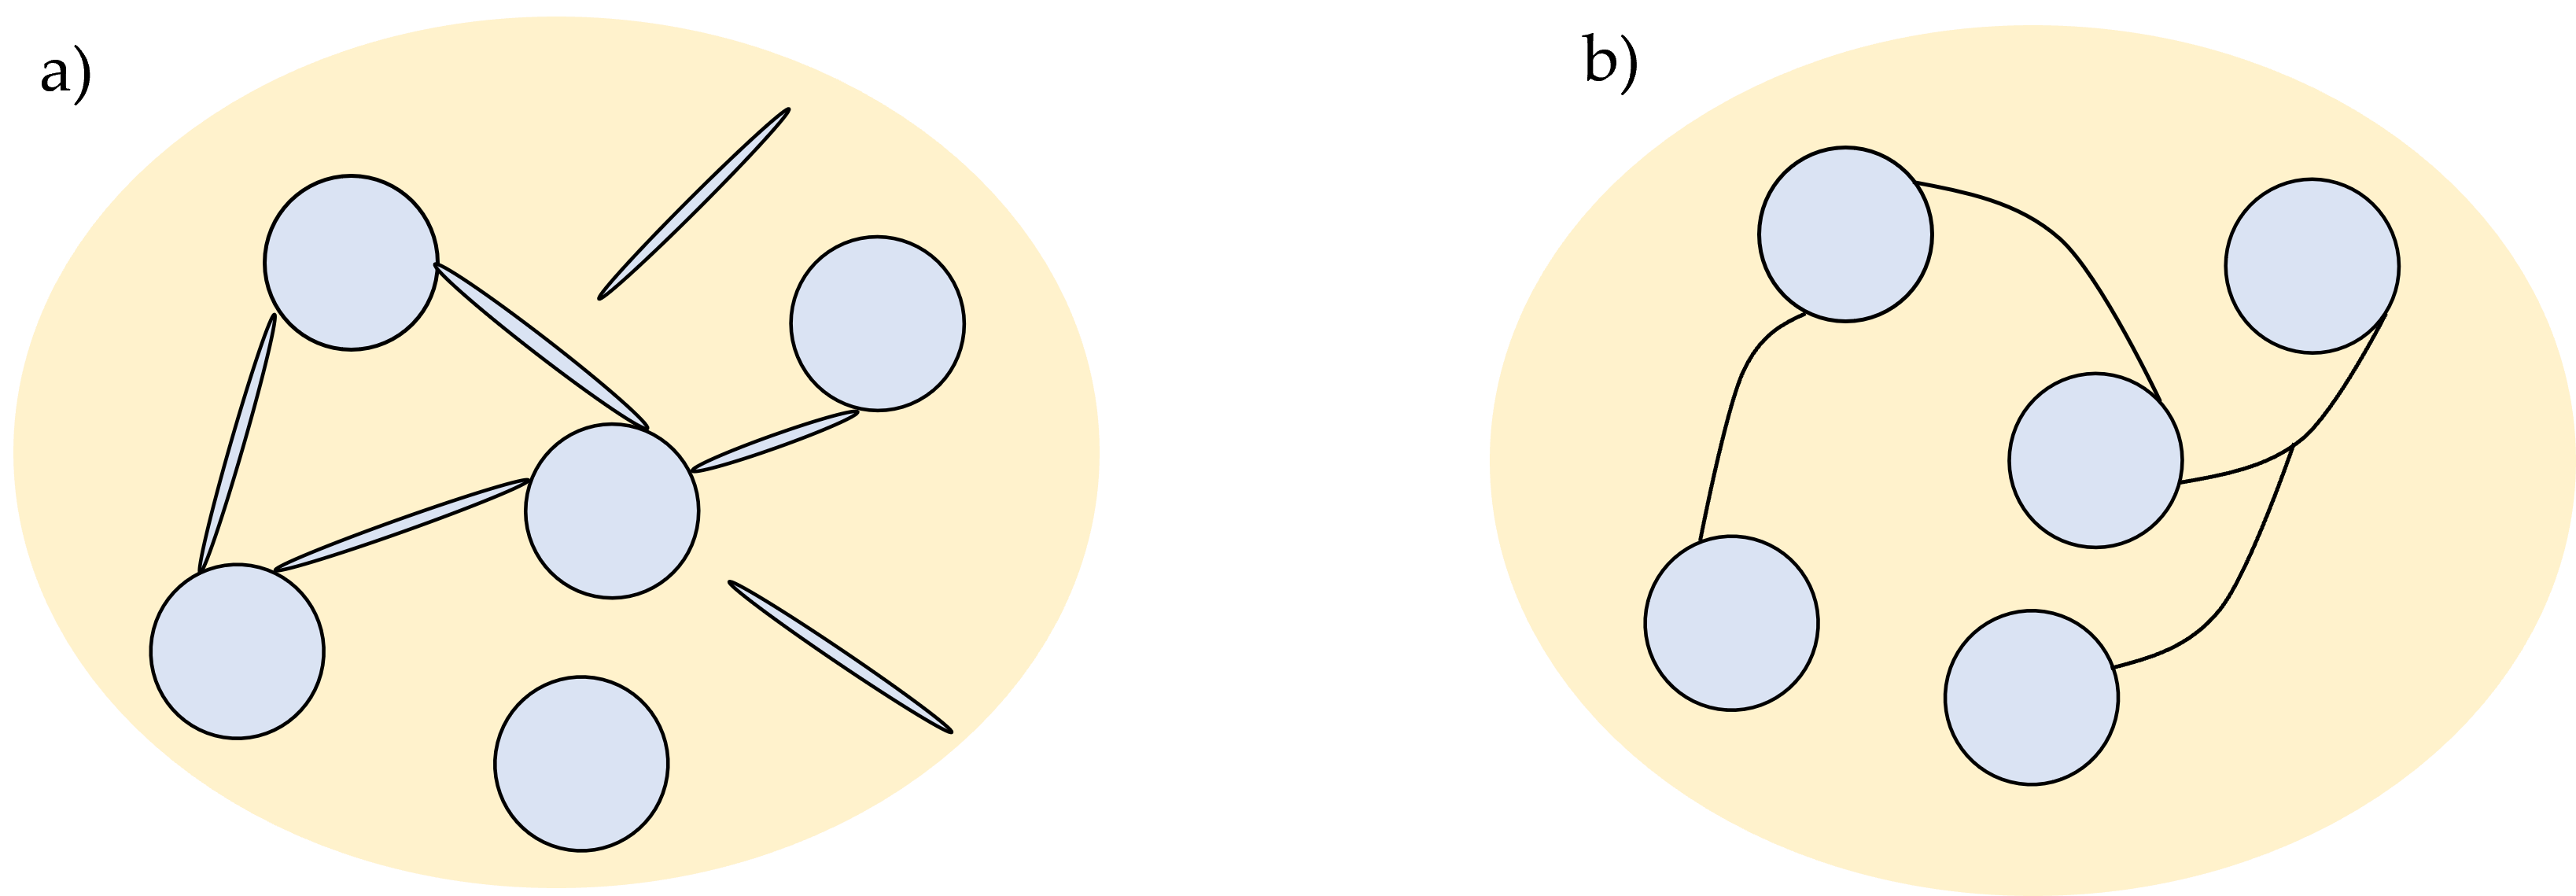
</div>

Figure 1. The illustration of proposed models: a) double porosity model (Type 1 model), b) f-model (Type 2 model).

The first one (Type 1 model) is a double porosity model (Figure 1a). It consists of an isotropic matrix and two types of voids – pores and randomly oriented cracks saturated with a fluid. Crack aspect ratio $\alpha_{crack}$ varies from 0.00001 to 0.1, and crack volume fraction (crack porosity) $\phi_{crack}$ does not exceed 2%. Pore aspect ratio $\alpha_{pore}$ is equal to 1. The aspect ratio of calcite grains is also equal to 1. 

The second model (Type 2 model) is a so-called $f$-model (Figure 1b) [Bayuk et al., 2007], which takes into account the connectivity of the voids via a special parameter f. In contrast to the double porosity model here only spherical saturated pores are embedded in the matrix. An empirical factor f reflects the connectivity of the pores and varies from 0 to 1. Pore volume fraction ϕpore changes from 0 to 20% for both models.

Considering the carbonate rock model, we use the calcite matrix with brine and gas-filled voids. The calcite bulk and shear moduli are equal to 72.0 and 32.0 GPa re-spectively. The brine bulk modulus is 2.5 GPa and the gas bulk modulus is 0.006 GPa. The shear modulus of fluids is zero.

# Methods comparison

In [42]:
# choose spherical porosity range
all_Kp = [0.02, 0.05, 0.10, 0.15, 0.2]

## Berryman and Berryman-f

Berryman’s method [Berryman 1980 a,b]:

$\sum_{\mathrm{i=1}}^{\mathrm{N}}{\mathrm{\nu}_\mathrm{i}\left(\mathrm{K}_\mathrm{i}\ \mathrm{-\ } \mathrm{K}_{\mathrm{SC}}^\mathrm{*}\right)\mathrm{P}^{\mathrm{*i}}}\mathrm{=\ 0},\ \
\sum_{\mathrm{i=1}}^{\mathrm{N}}{\mathrm{\nu}_\mathrm{i}\left(\mathrm{\mu}_\mathrm{i}\ \mathrm{-\ } \mathrm{\mu}_{\mathrm{SC}}^\mathrm{*}\right)\mathrm{Q}^{\mathrm{*i}}}\mathrm{=\ 0},
$ $\  \$ (1)

where $\mathrm{K}_{\mathrm{SC}}^\mathrm{*}$ and $\mathrm{\mu}_{\mathrm{SC}}^\mathrm{*}$ are the elastic moduli of the effective medium, $\mathrm{K}_\mathrm{i}$ and $\mathrm{\mu}_\mathrm{i}$ are the elastic moduli of inclusions, $\nu_i$ are volume fractions of inclusions, N is the number of inclusion types. The coefficients $\mathrm{P}^{\mathrm{*i}}$ and $\mathrm{Q}^{\mathrm{*i}}$ depend on the inclusion’s shape and properties of the effective medium. Equations of the $\mathrm{P}^{\mathrm{*i}}$ and $\mathrm{Q}^{\mathrm{*i}}$ for the general case of ellipsoidal inclusions are rather bulky and are not shown here. They can be found in [Kuster, Toksöz, 1974]. Equations (1) contain unknown effective elastic moduli in the both left- and right-hand sides. Such equations are solved by iterations.

Berryman-f --- Berryman’s formulas accounting for pore connectivity. Note that in this case there is no need for an iteration scheme as for Equation (1). 

$\mathrm{K}_{\mathrm{SC-f}}^\mathrm{*}\mathrm{\ \ =\ }\sum_{\mathrm{i=1}}^{\mathrm{N}}{\mathrm{\nu}_\mathrm{i}\mathrm{K}_\mathrm{i}\mathrm{P}^{\mathrm{Ci}}}\mathrm{/}\sum_{\mathrm{i=1}}^{\mathrm{N}}{\mathrm{\nu}_\mathrm{i}\mathrm{P}^{\mathrm{Ci}}}, \mathrm{\mu}_{\mathrm{SC-f}}^\mathrm{*}\mathrm{\ \ =\ }\sum_{\mathrm{i=1}}^{\mathrm{N}}{\mathrm{\nu}_\mathrm{i}\mathrm{\mu}_\mathrm{i}\mathrm{Q}^{\mathrm{Ci}}}\mathrm{/}\sum_{\mathrm{i=1}}^{\mathrm{N}}{\mathrm{\nu}_\mathrm{i}\mathrm{Q}^{\mathrm{Ci}}}$, $\   \$(2)



where $\mathrm{P}^{\mathrm{Ci}}$ and $\mathrm{Q}^{\mathrm{Ci}}$ are evaluated similar to those as in Equations (1) and $\mathrm{K}^\mathrm{*}\mathrm{\ =\ }\mathrm{K}^\mathrm{C}$, $\mathrm{\mu}^\mathrm{*}\mathrm{\ =\ }\mathrm{\mu}^\mathrm{C}$. The comparison body moduli $\mathrm{K}^\mathrm{C}$ and $\mathrm{\mu}^\mathrm{C}$ are found with following equation:
$\mathrm{K}^\mathrm{C}\mathrm{\ =\ }\left(\mathrm{1\ -\ f}\right)\mathrm{K}^\mathrm{M}\mathrm{\ +\ f}\mathrm{K}^{\mathrm{fl}}, \mathrm{\mu}^\mathrm{C}\mathrm{\ =\ }\left(\mathrm{1\ -\ f}\right)\mathrm{\mu}^\mathrm{M}\mathrm{\ +\ f}\mathrm{\mu}^{\mathrm{fl}}$, $\   \$(3)


In [97]:
#gas
p_1_g = Kp_asp_f('BBf', all_Kp, 'g', 1)
#brine
p_1_w = Kp_asp_f('BBf', all_Kp, 'w', 1)

##### GAS

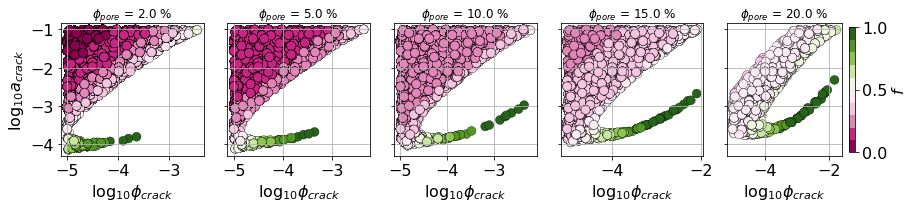

In [99]:
plot_scatter(p_1_g, all_Kp)

R2 = 0.79
f = 0.88 * log10(e)$  + 0.11*log10(e)^2 + 1.80
R2 = 0.70
f = 0.59 * log10(e)$  + 0.08*log10(e)^2 + 1.21
R2 = 0.65
f = 0.42 * log10(e)$  + 0.06*log10(e)^2 + 0.94
R2 = 0.59
f = 0.37 * log10(e)$  + 0.05*log10(e)^2 + 0.91
R2 = 0.83
f = 0.47 * log10(e)$  + 0.09*log10(e)^2 + 1.05


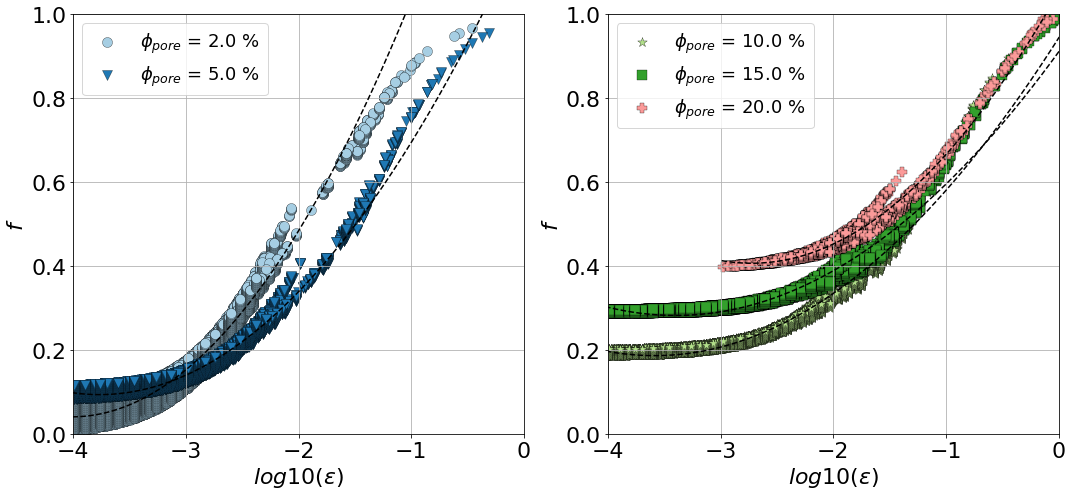

In [57]:
plot_crack_density(p_1_g, all_Kp, 2)

###### BRINE

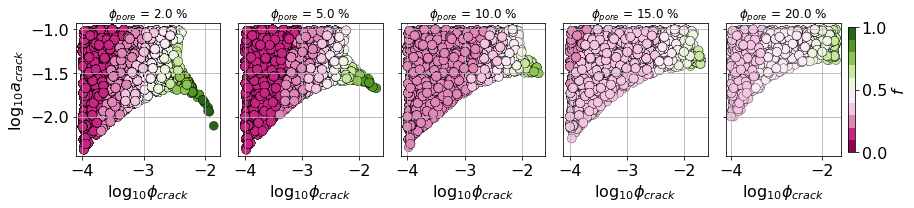

In [58]:
plot_scatter(p_1_w, all_Kp)

R2 = 0.70
f = 1.35 * log10(e)  + 0.23*log10(e)^2 + 0.00*log10(e)^3 + 2.23
R2 = 0.70
f = 1.34 * log10(e)  + 0.31*log10(e)^2 + 0.02*log10(e)^3 + 1.90
R2 = 0.71
f = 1.29 * log10(e)  + 0.37*log10(e)^2 + 0.03*log10(e)^3 + 1.69
R2 = 0.73
f = 1.08 * log10(e)  + 0.33*log10(e)^2 + 0.03*log10(e)^3 + 1.48
R2 = 0.79
f = 0.93 * log10(e)  + 0.29*log10(e)^2 + 0.03*log10(e)^3 + 1.38


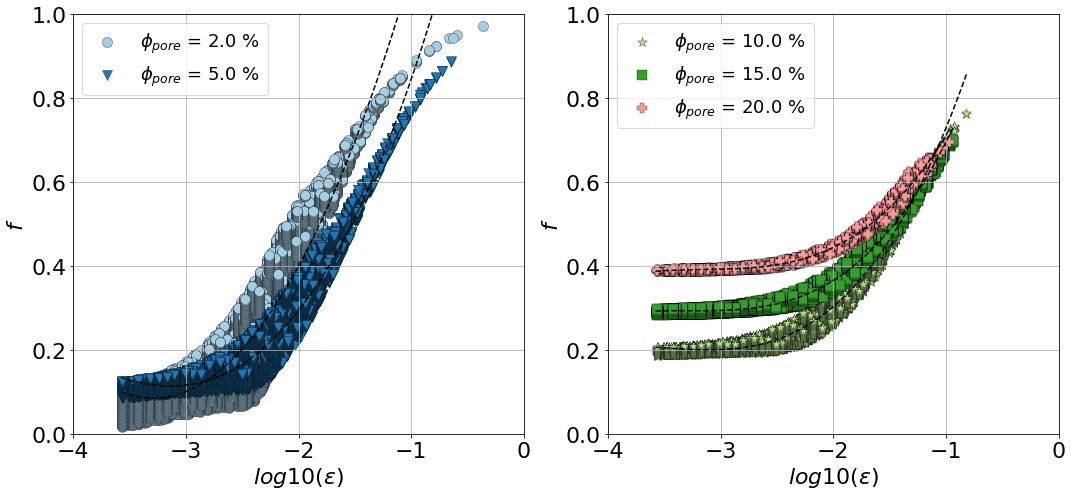

In [60]:
plot_crack_density(p_1_w, all_Kp, 3)

## DEM and Berryman-f

Differential effective medium theory [Norris 1985; Berryman 1992b] represents an iterative approach for calcu-lating the effective elastic properties. This approach consists of the sequential intro-duction of the entire volume of inclusions in infinitesimal portions. At each step, the problem of finding the effective elastic properties of a material consisting of a matrix and inclusions is solved by the self-consistent method, while the effective moduli calculated at the previous step are taken as the properties of the host medium. As a result, a nonlinear differential equation or a system of such equations of the first order is ob-tained for calculating the effective elastic moduli of the medium (Equations (4)). As an initial step, we can assume the equality of the elastic moduli of the effective medium to the elastic moduli of the mineral matrix. The equations have the form:

$\left(\mathrm{1\ -\ \nu}\right)\frac{\mathrm{\partial} \mathrm{K}_{\mathrm{DEM}}^\mathrm{*}}{\mathrm{\partial\nu}}\mathrm{=}\left(\mathrm{K}_\mathrm{i}\mathrm{\ -} {\mathrm{\ K}}_{\mathrm{DEM}}^\mathrm{*}\left(\mathrm{\nu}\right)\right)\mathrm{P}^{\mathrm{*i}},\left(\mathrm{1\ -\ \nu}\right)\frac{\mathrm{\partial} \mathrm{\mu}_{\mathrm{DEM}}^\mathrm{*}}{\mathrm{\partial\nu}}\mathrm{=}\left(\mathrm{\mu}_\mathrm{i}\mathrm{\ -} {\mathrm{\ K}}_{\mathrm{DEM}}^\mathrm{*}\left(\mathrm{\nu}\right)\right)\mathrm{Q}^{\mathrm{*i}}$ $\  \$(4)

where ${\mathrm{K}}_{\mathrm{DEM}}^\mathrm{*}$ and ${\mathrm{\mu}}_{\mathrm{DEM}}^\mathrm{*}$  are elastic moduli of the effective medium, $\mathrm{K}_\mathrm{i}$ and $\mathrm{\mu}_\mathrm{i}$ are the elastic moduli of inclusions, $\nu$ is volume fraction of inclusion which equals porosity here; $\mathrm{P}^{\mathrm{*i}}$ and $\mathrm{Q}^{\mathrm{*i}}$ depend on the shape of the inclusions and properties of the host (effective) medium. 
One practical detail of application of the DEM is that the final result for medium with several kinds of inclusions would depend on embedding order of different components into the matrix.


In [103]:
#gas
p_2_g = Kp_asp_f('DEMBf', all_Kp, 'g', 1)
#brine
p_2_w = Kp_asp_f('DEMBf', all_Kp, 'w', 1)

##### GAS

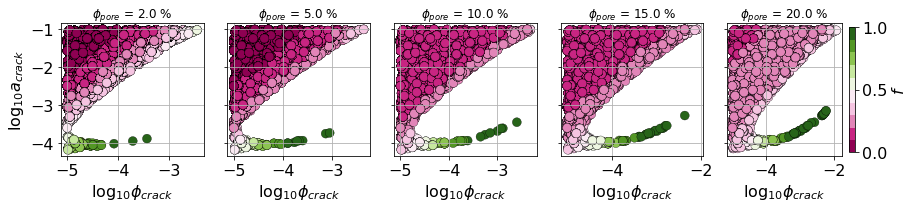

In [104]:
plot_scatter(p_2_g, all_Kp)

R2 = 0.78
f = 0.92 * log10(e)$  + 0.12*log10(e)^2 + 1.86
R2 = 0.69
f = 0.62 * log10(e)$  + 0.08*log10(e)^2 + 1.21
R2 = 0.63
f = 0.46 * log10(e)$  + 0.06*log10(e)^2 + 0.92
R2 = 0.58
f = 0.40 * log10(e)$  + 0.06*log10(e)^2 + 0.82
R2 = 0.55
f = 0.36 * log10(e)$  + 0.05*log10(e)^2 + 0.79


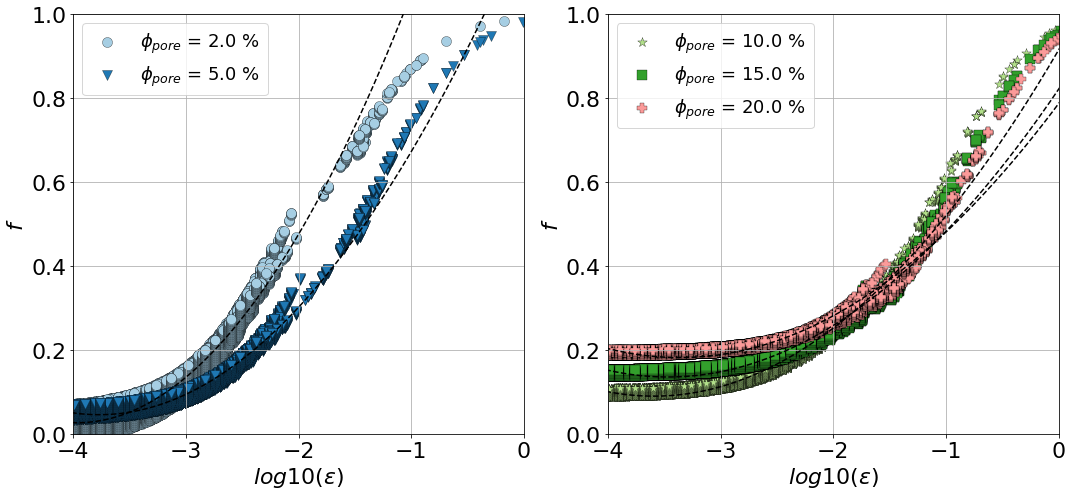

In [105]:
plot_crack_density(p_2_g, all_Kp, 2)

##### BRINE

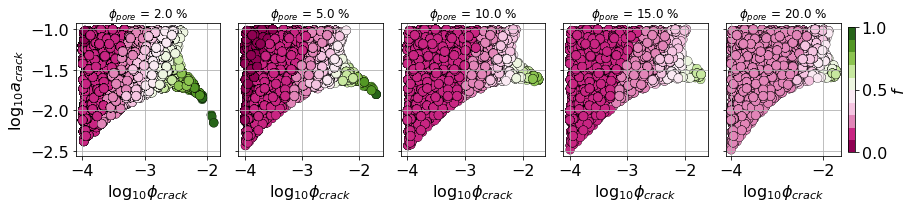

In [72]:
plot_scatter(p_2_w, all_Kp)

R2 = 0.70
f = 1.25 * log10(e)$  + 0.19*log10(e)^2 + 2.13
R2 = 0.70
f = 1.01 * log10(e)$  + 0.16*log10(e)^2 + 1.62
R2 = 0.68
f = 0.78 * log10(e)$  + 0.13*log10(e)^2 + 1.24
R2 = 0.68
f = 0.63 * log10(e)$  + 0.11*log10(e)^2 + 1.05
R2 = 0.69
f = 0.53 * log10(e)$  + 0.09*log10(e)^2 + 0.94


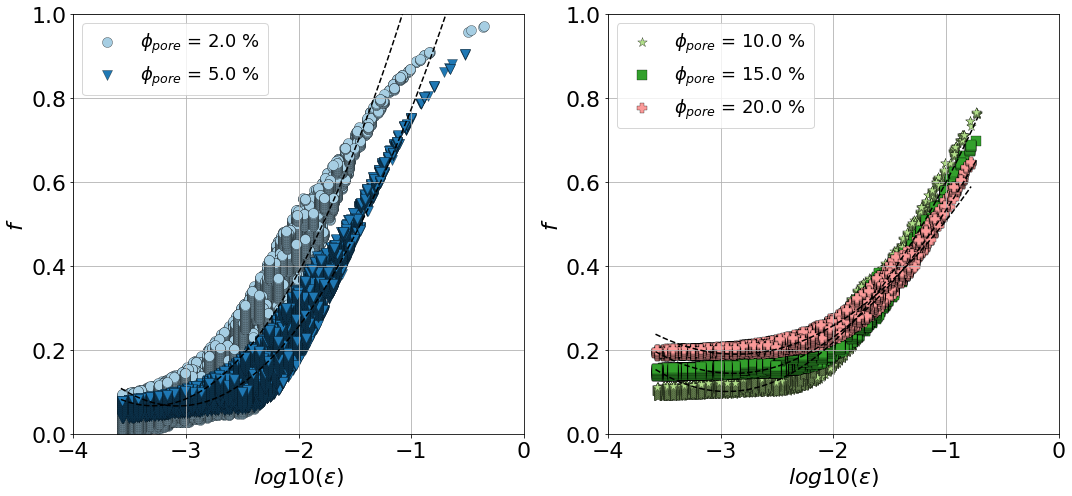

In [73]:
plot_crack_density(p_2_w, all_Kp, 2)

## GSA(double porosity) and GSA-f

Generalized singular approximation method:
The general formula for effective stiffness tensor $\mathbf{C}^\ast$ evaluation in the GSA method is:
 
$\mathrm{C}^\mathrm{*}\mathrm{=}\langle{\mathbf{C}(\mathbf{r})[\mathbf{I} - \mathbf{g}\mathbf{C}^{\prime}(\mathbf{r})]^{-1}}\rangle\langle[\mathbf{I} - \mathbf{g}\mathbf{C}^{\prime}(\mathbf{r})]^{-1}\rangle^{-1}$, $\   \$(5)

where angle brackets mean averaging over the representative volume; $\mathbf{C}\left(\mathbf{r}\right)$ is the fourth-rank tensor of the elastic constants related to the calcite matrix or fluid filling the voids; $I$ is the unit fourth-rank tensor; $\mathbf{g}$ is the Green function tensor, defined by the equation:
${\mathrm{\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ g}}_{\mathrm{ijkl}}\mathrm{\ =\ \ -}\frac{\mathrm{1} }{\mathrm{16\pi}}\int_{\mathrm{0}}^{\mathrm{2\pi}}\int_{\mathrm{0}}^{\mathrm{\pi}}\left(\mathrm{n}_{\mathrm{kj}}\mathrm{\Lambda}_{\mathrm{il\ }}^{\mathrm{-1}}\mathrm{\ +\ } \mathrm{n}_{\mathrm{ki}}\mathrm{\Lambda}_{\mathrm{jl}}^{\mathrm{-1}}\mathrm{\ +} {\mathrm{\ n}}_{\mathrm{lj}}\mathrm{\Lambda}_{\mathrm{ik}}^{\mathrm{-1}}\mathrm{\ +} {\mathrm{\ n}}_{\mathrm{li}}\mathrm{\Lambda}_{\mathrm{jk}}^{\mathrm{-1}}\right)\mathrm{sin\theta d\theta d\varphi} $,	(6)


where $\mathrm{\theta\ \in}\left[\mathrm{0,\pi}\right]\mathrm{,\ \varphi\ \in}\left[\mathrm{0,2\pi}\right)$ and $\mathrm{\Lambda}_{\mathrm{ij}}\mathrm{\ =\ \ }\mathrm{C}_{\mathrm{ijkl}}^\mathrm{c}\mathrm{n}_\mathrm{k}\mathrm{n}_\mathrm{l}\mathrm{,\ \ i,\ j,\ k,\ l=1,\ 2,\ 3}$ 

with $n_1=\frac{1}{a_1}sin{\theta}cos{\phi}, n_2=\frac{1}{a_2}sin{\theta}sin{\phi},n_3=\frac{1}{a_3}cos{\theta}$; 

$ a_1, a_2, a_3 $  are semi-axes of the ellipsoidal inclusions. 

The tensor $\mathbf{C}^{\prime}(\mathbf{r})\equiv \mathbf{C}(\mathbf{r})-\mathbf{C}^C$ is the fluctuation of the stiffness tensor. 

The tensor $\mathbf{C}^{C}$ is the elastic tensor of the comparison body whose parameters could be arbitrary.

If we set $\mathbf{C}^{C}$ equal to the stiffness tensor of the medium with the effective properties $ \mathbf{C}^{C} =\mathbf{C}^{*}$, then it gives us the formulas of the self-consistent method (GSA-SC) [Willis, 1977; Shermergor 1977].

If we consider porous space connectivity in the f-model, we express the comparison body properties as a linear combination of the matrix and fluid properties according to Equation (3) [Bayuk and Chesnokov, 1998]:

$\mathbf{C}^{C} = (1 - f)\mathbf{C}^{M} + f\mathbf{C}^{fl}$, $\   \$(7)

where $\mathbf{C}^{M}$ and $\mathbf{C}^{fl}$ are, respectively, the stiffness tensor of the mineral matrix (the stiffest component) and fluid filling the voids (the softest component).



In [86]:
#gas
p_3_g = Kp_asp_f('GSA', all_Kp, 'g', 1)
#brine
p_3_w = Kp_asp_f('GSA', all_Kp, 'w', 1)

##### GAS

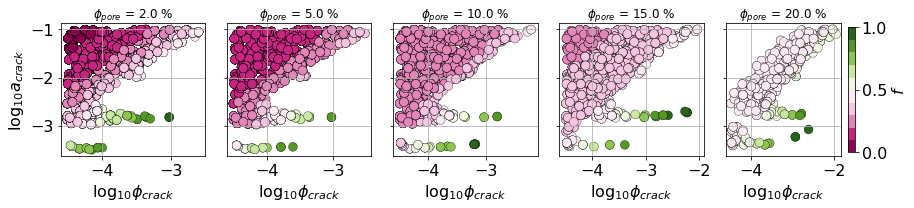

In [88]:
plot_scatter(p_3_g, all_Kp)

R2 = 0.87
f = 0.84 * log10(e)$  + 0.10*log10(e)^2 + 1.72
R2 = 0.78
f = 0.66 * log10(e)$  + 0.09*log10(e)^2 + 1.29
R2 = 0.68
f = 0.53 * log10(e)$  + 0.08*log10(e)^2 + 1.08
R2 = 0.63
f = 0.45 * log10(e)$  + 0.07*log10(e)^2 + 1.00
R2 = 0.84
f = 0.50 * log10(e)$  + 0.09*log10(e)^2 + 1.09


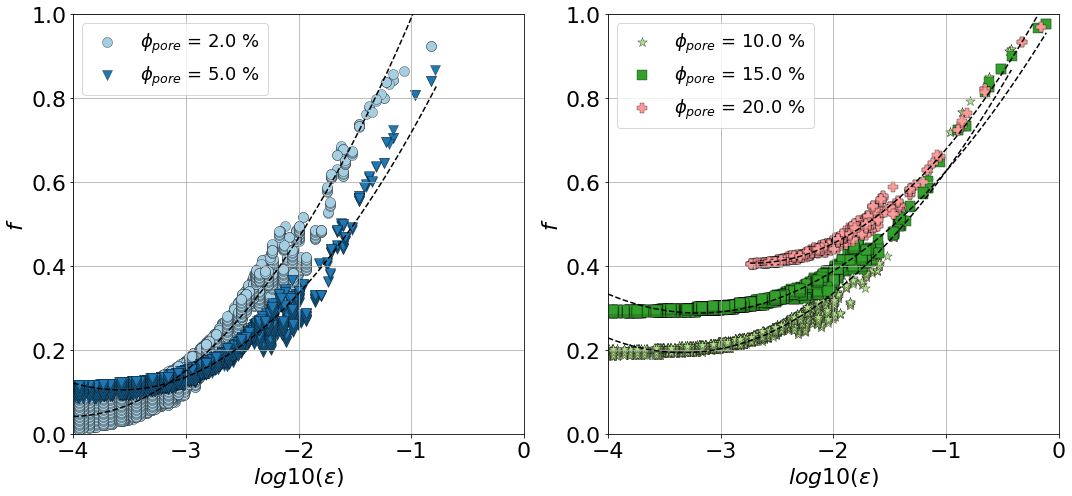

In [89]:
plot_crack_density(p_3_g, all_Kp, 2)

##### BRINE

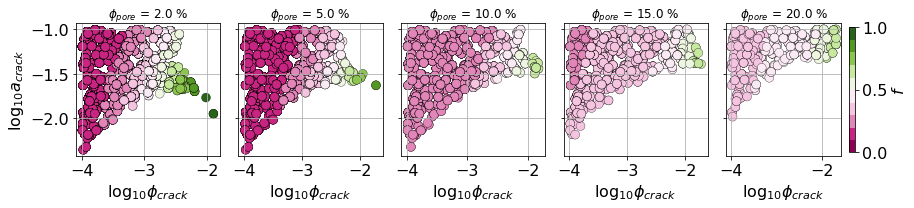

In [90]:
plot_scatter(p_3_w, all_Kp)

R2 = 0.71
f = 1.23 * log10(e)$  + 0.19*log10(e)^2 + 2.12
R2 = 0.70
f = 0.99 * log10(e)$  + 0.16*log10(e)^2 + 1.64
R2 = 0.70
f = 0.74 * log10(e)$  + 0.12*log10(e)^2 + 1.29
R2 = 0.73
f = 0.55 * log10(e)$  + 0.09*log10(e)^2 + 1.11
R2 = 0.78
f = 0.46 * log10(e)$  + 0.08*log10(e)^2 + 1.06


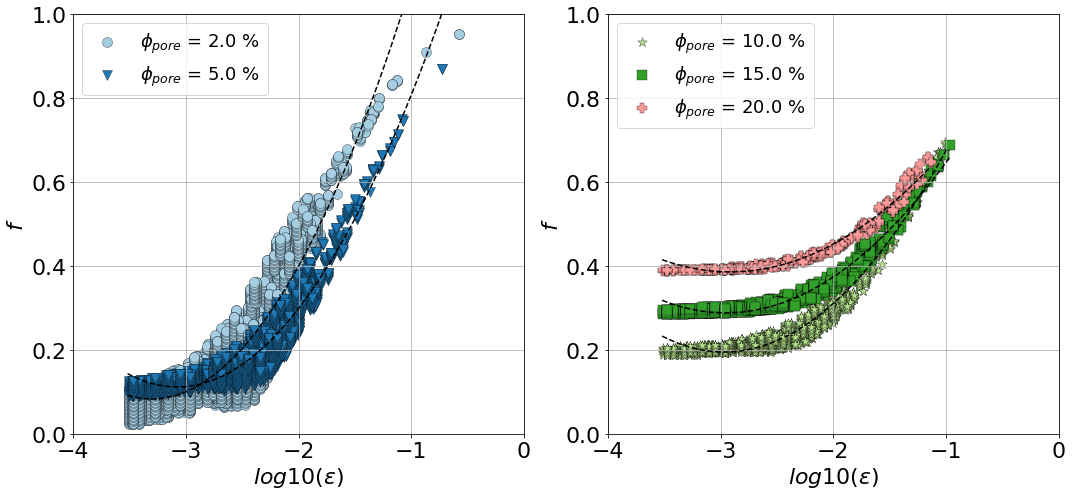

In [91]:
plot_crack_density(p_3_w, all_Kp, 2)

# References

Bayuk, I.O.; Chesnokov, E.M. Correlation between elastic and transport properties of porous cracked anisotropic media. Phys.Chem. Earth 1998, 23, 361–366.

Berryman, J.G. Long-wavelength propagation in composite elastic media. J. Acoust. Soc. Am. 1980, 68, 1809–1831.

Berryman, J.G.; Pride, S.R.; and Wang, H.F. A differential scheme for elastic properties of rocks with dry or saturated cracks. In Proc. 15th ASCE Engineering Mechanics Conference, 1992.

Kuster, G.T. and Toksoz, M.N. Velocity and attenuation of seismic waves in two-phase media. Geophys. 1974, 39, 587–618.

Norris, A.N.; Sheng, P. and Callegari, A.J. Effective-medium theories for two-phase dielectric media. J. Appl. Phys. 1985, 57, 1990–1996.

Shermergor, T.D. Theory of Elasticity of Heterogeneous Media; Nauka: Moscow, Russia, 1977. (In Russian).

Willis, J. Bounds and self-consistent estimates for the overall properties of anisotropic composites. J. Mech. Phys. Solids 1977, 25, 185–202.